# Simple travel planner system

Planning a personalized day trip involves multiple steps of information gathering and synthesis - understanding the destination, learning about traveler preferences, and creating a tailored itinerary that matches those interests. We are going to build an interactive AI agent that guides users through a natural conversation to gather requirements and generate personalized travel recommendations.

This notebook demonstrates how to create a conversational AI agent that maintains context across multiple interactions. This travel planner needs to actively engage with users, remember their responses, and build upon that information to create meaningful outputs.

The key challenge we're solving is stateful conversation management - how to maintain continuity across multiple user interactions while ensuring each step builds logically on the previous ones. Our agent will demonstrate three essential capabilities of conversational AI: information gathering, context retention, and personalized generation.

In [1]:
import os
from typing import TypedDict, Union, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Configure OpenAI API key for AI model access
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

- The `HumanMessage` and `AIMessage` imports enable us to maintain a proper conversation history that distinguishes between user inputs and AI responses in our state management.

## Define agent state
To enable a meaningful, multi-turn conversation, our AI agent needs to remember and manage context across several steps. Unlike simple chatbots that treat every message independently, our travel planner requires the agent to accumulate user inputs and maintain a working memory of the session.

The goal of this state definition is to:
- **Track the full conversation history** so the agent can refer back to previous messages.
- **Extract structured information** (such as the city and interests) as the conversation unfolds.
- **Store and return the final output** (a generated itinerary) once all necessary details are collected.

This serves as the agent's memory and context management system.

In [2]:
# Define the comprehensive state structure for our conversational AI agent
class PlannerState(TypedDict):
    messages: List[Union[HumanMessage, AIMessage]]  # Complete conversation history, including both user and AI messages
    city: str  # Destination city extracted from user input
    interests: List[str]  # User's travel interests parsed from conversation
    itinerary: str  # Final generated travel plan

The `PlannerState` class defines our agent's conversational memory architecture.
- We use `TypedDict` from Python’s typing module, which allows us to define dictionaries with specific fields and expected types, making our state structure both readable and type-safe. This is especially useful in larger applications or collaborative projects where clarity matters.
- The `messages` field creates a chronological record of the entire conversation containing both `HumanMessage` and `AIMessage` objects, enabling our agent to reference previous exchanges and maintain context. Unlike simple request-response systems, this structure allows our agent to build understanding progressively.
- The specific fields (`city`, `interests`, `itinerary`) represent extracted structured information that gets populated as the conversation progresses, transforming unstructured dialogue into actionable data for travel planning. When a node function returns a dictionary, LangGraph automatically merges it with the existing state, updating only the specified keys while preserving others.

## Set up the language model
Here we instantiate a chat model that will be used to understand context and generate the travel itinerary.

In [3]:
# Initialize the language model
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18")

We are using `GPT-4o-mini` without temperature specification, allowing for natural conversational variability while maintaining relevance. This model choice provides strong contextual understanding necessary for multi-turn conversations while being cost-effective for interactive applications.

## Set up prompt template for itinerary generation
Before building our conversation flow, we need to design how our AI agent will generate the final travel itinerary. This template structures how the accumulated conversation context gets transformed into actionable travel recommendations. We create a instructional prompt template to be passed to the model when it is time to generate the itinerary.

In [4]:
# Design the prompt template for itinerary generation
itinerary_prompt = ChatPromptTemplate.from_messages([
    # System message defines assistant's behavior and output format
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    # Human message simulates the final instruction from the user
    ("human", "Create an itinerary for my day trip."),
])

- The `ChatPromptTemplate.from_messages` method accepts a sequence of roles and corresponding messages, mimicking the conversational format used by most chat-based language models (like GPT-4). LangChain’s `ChatPromptTemplate` makes it easy to define reusable, dynamic prompts. It separates system instructions (which shape the assistant’s behavior) from user queries (which simulate the final interaction). By defining both, we provide the model with a clear role and purpose, and we simulate a realistic context to ground the generation process. In this template:
  - The system message plays a crucial role in defining behavior, tone, and structure. It tells the model what kind of assistant it is and exactly what kind of output is expected—concise, bulleted, and travel-specific. This ensures consistent generation across different inputs.
  - The human message simulates the final request, creating a complete interaction context for the language model.
- This prompt template demonstrates how conversational context gets transformed into structured output. The system message establishes the agent's role and output format, while the template variables `{city}` and `{interests}` represent information extracted from the conversation flow.

This approach ensures consistent, well-formatted travel recommendations regardless of how the conversation unfolds.


## Define agent functions
Now, we will implement the core conversational behavior of our AI agent. LangGraph enables us to structure conversations as graphs of executable functions, where each node performs a well-defined operation on shared state. Each function represents a specific step in our guided conversation: get city, get interests, create itinerary.

In [5]:
# Collect the user's desired travel destination
def input_city(state: PlannerState) -> PlannerState:
    print("Please enter the city you want to visit for your day trip:")
    user_message = input("Your input: ")  # Prompts user for travel destination

    # Update agent state with new information and conversation history
    return {
        **state,  # Preserve existing conversation context
        "city": user_message, # Save the city to the state
        "messages": state['messages'] + [HumanMessage(content=user_message)],  # Append message to conversation history
    }

# Collect the user's travel interests for the chosen city
def input_interests(state: PlannerState) -> PlannerState:
    print(f"Please enter your interests for the trip to {state['city']} (comma-separated):")
    user_message = input("Your input: ")  # Prompts user for travel interests

    # Process and structure the user's interest input
    return {
        **state,  # Maintain conversation continuity
        "interests": [interest.strip() for interest in user_message.split(',')],  # Parse interests into structured list
        "messages": state['messages'] + [HumanMessage(content=user_message)],  # Update conversation history
    }

# Generate the itinerary based on collected user inputs
def create_itinerary(state: PlannerState) -> PlannerState:
    print(f"Creating an itinerary for {state['city']} based on interests: {', '.join(state['interests'])}...")

    # Generate personalized itinerary using accumulated conversation context
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))

    # Present the generated itinerary to the user
    print("\nFinal Itinerary:")
    print(response.content)

    # Update conversation state with AI-generated response
    return {
        **state,  # Preserve complete conversation context
        "messages": state['messages'] + [AIMessage(content=response.content)],  # Add AI response to history
        "itinerary": response.content,  # Store structured itinerary output
    }

These functions operate over the shared `PlannerState` data structure we defined earlier, ensuring context is maintained throughout the process. Importantly, each function appends new messages to the agent’s conversation history, which gives the model context for its responses.
- The `input_city` function prompts the user for a destination and stores it in the state. It also appends the user input to the messages list, which is important for maintaining conversation continuity.
- In `input_interests`, we ask for the user’s interests, parse them into a clean list format, and again update both the state and message history. This structured representation is essential for prompt templating later on.
- Finally, `create_itinerary` calls the language model using the pre-defined prompt template. It formats the prompt with the collected city and interests, sends it to the model, and captures the AI-generated itinerary. The result is printed to the console and stored in the state for future access or logging.

Those functions demonstrate LangGraph's state update mechanism.
- The `input()` function pauses execution and waits for user input from the console.
- The return statement uses dictionary unpacking (`**state`) to preserve all existing state keys while overriding specific ones. LangGraph's state management automatically merges this returned dictionary with the current state - any keys present in the return value update the state, while missing keys remain unchanged.
- The `HumanMessage(content=user_message)` creates a typed message object that gets appended to the existing messages list.
- The `state['messages'] + [new_message]` syntax creates a new list rather than modifying the existing one, which is important for LangGraph's state tracking.
- `", ".join(state['interests'])` converts the interests list back into a comma-separated string for prompt insertion.
- The `itinerary_prompt.format_messages()` method substitutes the template variables with actual values and returns a list of formatted message objects.
- `llm.invoke()` sends these messages to the OpenAI API and returns an `AIMessage` object.

## Create and compile the graph
With our individual conversation functions defined, we will now assemble them into a coherent conversational flow that guides users through our travel planning process naturally and efficiently.

In [6]:
# Construct the conversational workflow using StateGraph
workflow = StateGraph(PlannerState)

# Add each conversational step as a node in our agent's workflow
workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

# Define the conversational flow sequence
workflow.set_entry_point("input_city")
workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)

# Compile the workflow into an executable conversational agent
app = workflow.compile()

This code constructs a directed acyclic graph (DAG) representing our conversation flow.
- `StateGraph(PlannerState)` creates a graph that will manage state objects of type `PlannerState`.
- Each `add_node()` call registers a function with a string identifier - LangGraph will call these functions in sequence, passing the current state and expecting a partial state update in return.
- `set_entry_point()` defines which node executes first when the graph runs.
- The `add_edge()` calls create directed connections between nodes, forming a linear execution path.
- `END` is a special LangGraph constant representing graph termination.
- The `compile()` method validates the graph structure and returns an executable object with methods that can run the entire workflow.

### Display the graph structure
Let's visualize our conversational agent's internal structure to understand how information flows through the guided conversation process.

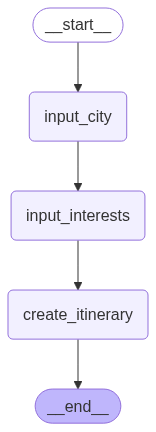

In [7]:
# Generate visual representation of our conversational agent's workflow
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

- The `app.get_graph()` method returns a graph representation object that contains the node and edge structure we defined.
- The `.draw_mermaid_png()` method generates a Mermaid diagram syntax and renders it as a PNG image using the specified API method.
- `MermaidDrawMethod.API` tells LangGraph to use an external service to convert the Mermaid syntax to an image.
- The `display()` and `Image()` functions are Jupyter notebook utilities that render the binary PNG data as an inline image in the notebook output.

This visualization shows the nodes as boxes connected by arrows, making the linear flow clearly visible.

### Define the function that runs the graph
Now we will create the system that orchestrates complete conversation sessions, managing the flow from initial user intent through final itinerary delivery.

In [8]:
# Define the function that orchestrates complete conversation sessions
def run_travel_planner(user_request: str):
    print(f"Initial Request: {user_request}\n")

    # Initialize conversation state with user's initial request
    state = {
        "messages": [HumanMessage(content=user_request)],  # Start conversation history
        "city": "",  # Empty until gathered from user
        "interests": [],  # Empty until gathered from user
        "itinerary": "",  # Empty until generated by AI
    }

    # Execute the complete conversational workflow - each step will handle user interaction and state updates
    for output in app.stream(state):
        pass  # The individual nodes handle all user interaction and output

This function initializes a complete state dictionary that conforms to the `PlannerState` structure.
- The initial state contains the user's request as a `HumanMessage` in the messages list, while other fields are set to empty defaults.
- The `app.stream(state)` method executes the graph iteratively, calling each node function in sequence and updating the state after each step.
- The `stream()` method returns a generator that yields intermediate states, but since our node functions handle their own output via `print()` statements, we don't need to process these intermediate results.
- The `for` loop simply iterates through all steps until the graph reaches the END node and terminates.

## Use case example
Finally, let's demonstrate our complete conversational AI agent by running through a typical travel planning session.

In [9]:
# Demonstrate our conversational AI agent with a typical use case
user_request = "I want to plan a day trip."
run_travel_planner(user_request)

Initial Request: I want to plan a day trip.

Please enter the city you want to visit for your day trip:


Your input:  New York City


Please enter your interests for the trip to New York City (comma-separated):


Your input:  food


Creating an itinerary for New York City based on interests: food...

Final Itinerary:
Sure! Here’s a food-focused day trip itinerary for New York City:

### New York City Foodie Day Trip Itinerary

**Morning: Brunch in the East Village**
- **Time:** 9:00 AM - 10:30 AM
- **Location:** *Cafe Mogador*
  - Enjoy their famous Moroccan eggs or classic brunch options.
- **Tip:** Don't forget their delicious coffee and fresh juice!

**Mid-Morning: Bakery Stop**
- **Time:** 10:45 AM - 11:15 AM
- **Location:** *Dominique Ansel Bakery*
  - Try the iconic Cronut or a cookie shot with milk.

**Late Morning: Gourmet Food Hall**
- **Time:** 11:30 AM - 1:00 PM
- **Location:** *Chelsea Market*
  - Explore a variety of food vendors and sample seafood, tacos, and artisan cheese. 
- **Tip:** Grab some items for later!

**Afternoon: Iconic New York Lunch**
- **Time:** 1:15 PM - 2:30 PM
- **Location:** *Katz's Delicatessen*
  - Indulge in a classic pastrami sandwich and a pickle. Don’t forget to try their f

Here, we demonstrate the complete execution flow.
- When `run_travel_planner()` is called, it creates the initial state with this request as the first message, then invokes `app.stream()` to begin graph execution. The graph will execute nodes in sequence: first `input_city()` will run and prompt for user input, updating the state with the city and new message; then `input_interests()` will execute with the updated state, prompting for interests and updating the state again; finally `create_itinerary()` will run with all collected information, generate the AI response, and update the state with the final itinerary. Each function call is blocking until user input is provided, creating the interactive conversation experience.


The sequential conversation pattern we have implemented here is particularly valuable for applications requiring structured information gathering, making it applicable to domains beyond travel planning such as product recommendations, service configuration, or consultation workflows.